In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import torch

import tsvar

import experiments_utils

# Set numpy print format
np.set_printoptions(precision=2, floatmode='fixed', sign=' ')

# Set experiments verbosity
#experiments_utils.PRINT_EVERY = 1
#experiments_utils.CALLBACK_END = ''
PRINT_EVERY = 1
CALLBACK_END = ''
VI_N_ITER = 1000

In [16]:
dim = 10
max_jumps = int(1e5)
gen_seed = 1234
sim_seed = 789

print('Generate parameters:')
print('--------------------')
coeffs_true_dict = experiments_utils.generate_parameters(dim=dim, seed=gen_seed)
coeffs_true_dict = {k: np.array(v) for k, v in coeffs_true_dict.items()}
for k,v in coeffs_true_dict.items():
    print(f"{k}:")
    print(np.array(v))
print()

print('Simulate data:')
print('--------------')
events, end_time, sim_seed = experiments_utils.generate_data(**coeffs_true_dict, max_jumps=max_jumps)
print(f'Simulated {sum(map(len, events)):d} events')

Generate parameters:
--------------------
baseline:
[ 0.02  0.06  0.04  0.08  0.08  0.03  0.03  0.08  0.10  0.09]
beta:
[[ 0.72  1.00  1.37  1.43  0.74  1.12  1.01  0.03  1.55  1.77]
 [ 0.73  1.23  0.15  0.74  1.87  1.30  0.79  1.58  0.63  1.14]
 [ 1.74  0.87  1.60  0.29  1.41  1.41  0.44  1.85  0.88  1.82]
 [ 0.12  0.37  0.09  1.35  1.19  1.07  0.09  1.12  0.66  1.01]
 [ 0.22  1.21  1.13  0.01  1.23  1.82  1.58  1.98  1.92  1.58]
 [ 0.57  1.25  0.96  0.39  0.76  0.11  0.90  1.96  0.25  0.24]
 [ 1.48  1.17  0.94  0.21  0.46  1.80  0.83  1.07  0.01  0.60]
 [ 0.87  1.22  1.84  1.25  1.41  0.30  1.49  1.66  1.27  0.88]
 [ 0.31  1.14  1.06  1.90  0.96  1.01  1.07  1.64  0.11  1.34]
 [ 1.53  1.42  1.59  1.12  1.93  0.29  0.06  1.19  0.23  1.90]]
adjacency:
[[ 0.00  0.00  0.00  0.17  0.16  0.00  0.00  0.00  0.15  0.20]
 [ 0.14  0.10  0.19  0.19  0.00  0.00  0.00  0.12  0.00  0.00]
 [ 0.00  0.17  0.18  0.00  0.00  0.00  0.14  0.00  0.00  0.14]
 [ 0.00  0.10  0.11  0.16  0.00  0.00  0.11  0.00

In [17]:
class MyCallback(tsvar.utils.callbacks.LearnerCallbackMLE):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.extra = {
            'as_po': [],
            'ar_po': [],
            'bs_po': [],
            'br_po': [],
        }
    
    def __call__(self, learner_obj, end=None, force=False):
        super().__call__(learner_obj, end, force)
        self.extra['as_po'].append(learner_obj._as_po)
        self.extra['ar_po'].append(learner_obj._ar_po)
        self.extra['bs_po'].append(learner_obj._bs_po)
        self.extra['br_po'].append(learner_obj._br_po)

In [19]:
coeffs_true_dict['beta']

array([[ 0.72,  1.00,  1.37,  1.43,  0.74,  1.12,  1.01,  0.03,  1.55,  1.77],
       [ 0.73,  1.23,  0.15,  0.74,  1.87,  1.30,  0.79,  1.58,  0.63,  1.14],
       [ 1.74,  0.87,  1.60,  0.29,  1.41,  1.41,  0.44,  1.85,  0.88,  1.82],
       [ 0.12,  0.37,  0.09,  1.35,  1.19,  1.07,  0.09,  1.12,  0.66,  1.01],
       [ 0.22,  1.21,  1.13,  0.01,  1.23,  1.82,  1.58,  1.98,  1.92,  1.58],
       [ 0.57,  1.25,  0.96,  0.39,  0.76,  0.11,  0.90,  1.96,  0.25,  0.24],
       [ 1.48,  1.17,  0.94,  0.21,  0.46,  1.80,  0.83,  1.07,  0.01,  0.60],
       [ 0.87,  1.22,  1.84,  1.25,  1.41,  0.30,  1.49,  1.66,  1.27,  0.88],
       [ 0.31,  1.14,  1.06,  1.90,  0.96,  1.01,  1.07,  1.64,  0.11,  1.34],
       [ 1.53,  1.42,  1.59,  1.12,  1.93,  0.29,  0.06,  1.19,  0.23,  1.90]])

In [37]:
dim = len(events)
# Set model
model = tsvar.models.WoldModelVariational(verbose=True)
model.observe(events)

# Set priors

# prior: Alpha
as_pr = 1.0 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))

# prior: Beta
bs_pr = 100.0 * np.ones((dim, dim))
br_pr = 100.0 * np.ones((dim, dim))

# VERY INFORMATIVE BETA USING GROUND TRUTH!!
#bs_pr = 10000000.0 * np.ones((dim, dim))
#br_pr = (bs_pr - 1) * coeffs_true_dict['beta']

# prior: Z
zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]


# Extract ground truth (for callback, only alphas)
coeffs_true = np.hstack((
    coeffs_true_dict['baseline'],
    coeffs_true_dict['adjacency'].flatten()))

# Set callback (parameters of callback are just the posterior mean of alpha)
callback = MyCallback(
    x0=(as_pr / ar_pr).flatten(), print_every=PRINT_EVERY,
    coeffs_true=coeffs_true, acc_thresh=0.05, dim=dim,
    default_end=CALLBACK_END)

# Fit model
conv = model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr,
                 zc_pr=zc_pr, max_iter=VI_N_ITER, tol=1e-5, callback=callback)

# Save result
res_dict = {}
res_dict['coeffs'] = {
    'as_po': model._as_po.tolist(),
    'ar_po': model._ar_po.tolist(),
    'bs_po': model._bs_po.tolist(),
    'br_po': model._br_po.tolist(),
}
res_dict['conv'] = conv
res_dict['history'] = callback.to_dict()


iter:  1000 | dx: +9.2851e-05 | acc: 0.57 | relerr: 0.51 | time/it: 6.56e-01     

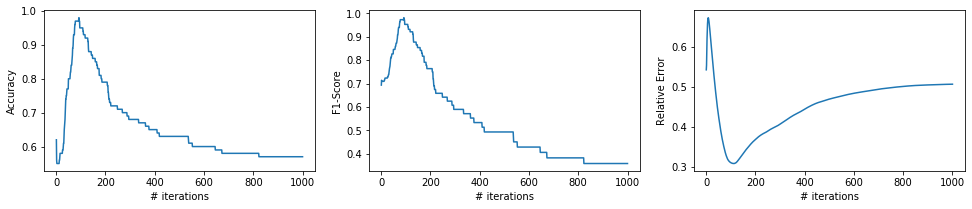

In [38]:
model = tsvar.models.WoldModelVariational()

x_iter = np.array(res_dict['history']['iter'], dtype=float)
y_acc = np.zeros_like(x_iter)
y_f1s = np.zeros_like(x_iter)
y_rel = np.zeros_like(x_iter)

adj_true = coeffs_true_dict['adjacency'].flatten()

for i, coeffs in enumerate(res_dict['history']['coeffs']):
    adj_hat = np.array(coeffs[-dim**2:])
    
    y_acc[i] = tsvar.utils.metrics.accuracy(adj_hat, adj_true, threshold=0.05)
    y_f1s[i] = tsvar.utils.metrics.fscore(adj_hat, adj_true, beta=1)
    y_rel[i] = tsvar.utils.metrics.relerr(adj_hat, adj_true)

fig, axs = plt.subplots(1, 3, figsize=(5.5*3, 2.95))
axs[0].plot(x_iter, y_acc)
axs[0].set_xlabel('# iterations')
axs[0].set_ylabel('Accuracy')

axs[1].plot(x_iter, y_f1s)
axs[1].set_xlabel('# iterations')
axs[1].set_ylabel('F1-Score')

axs[2].plot(x_iter, y_rel)
axs[2].set_xlabel('# iterations')
axs[2].set_ylabel('Relative Error');